In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
d_resid = 1000
class ToyMLP(torch.nn.Module):
    def __init__(self):
        super(ToyMLP, self).__init__()
        self.encoder = torch.nn.Linear(d_resid, 1, bias=False)
        self.decoder = torch.nn.Linear(1, d_resid, bias=False)

        # self.encoder.weight.data = torch.tensor([[-1.0, -1.0]])
        # self.decoder.weight.data = torch.tensor([[-1.0], [-1.0]])

    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(x)
        x = self.decoder(x)
        return x


In [3]:
original_encoder = torch.nn.functional.one_hot(torch.tensor([0]), num_classes=d_resid).type(torch.float32).T
original_decoder = torch.nn.functional.one_hot(torch.tensor([1]), num_classes=d_resid).type(torch.float32).T

In [17]:
toy_mlp = ToyMLP()

num_steps = 10000

normalise_decoder = False

optimizer = torch.optim.Adam(toy_mlp.parameters(), lr=0.01)
losses = []

enc_sims = []
dec_sims = []

for i in range(num_steps):
    # data is random normal
    x= torch.randn(8,d_resid)
    pred = toy_mlp(x)
    with torch.no_grad():
        target = x @ original_encoder
        target = F.relu(target)
        # target = F.gelu(target)
        target = target @ original_decoder.T
    loss = F.mse_loss(pred, target)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # normalize decoder weight to 1
    if normalise_decoder:
        toy_mlp.decoder.weight.data = toy_mlp.decoder.weight.data / toy_mlp.decoder.weight.data.norm(dim=0)

    losses.append(loss.item())

    # compute similarity between toy_mlp and original encoder
    enc_sim = torch.cosine_similarity(toy_mlp.encoder.weight, original_encoder.T)

    enc_sims.append(enc_sim[0].item())

    # compute similarity between toy_mlp and original decoder
    dec_sim = torch.cosine_similarity(toy_mlp.decoder.weight.T, original_decoder.T)

    dec_sims.append(dec_sim[0].item())


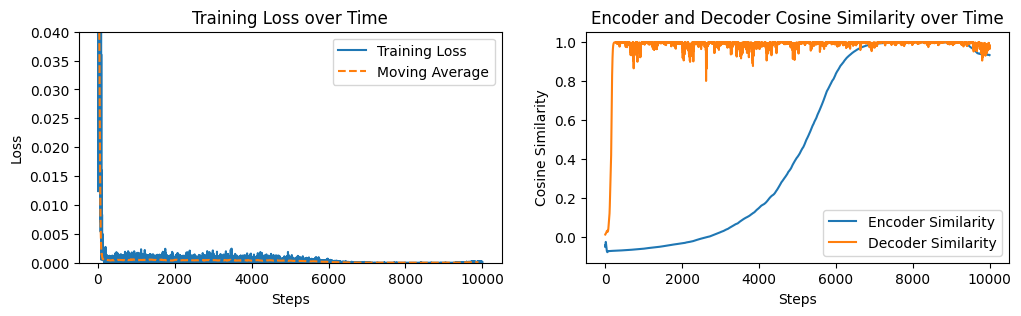

In [18]:

def moving_average(data, window_size):
    """Calculate the moving average using a given window size."""
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size

# Calculate moving average of the losses
losses_moving_avg = moving_average(losses, 100)

# Setting up the figure for side-by-side subplots
plt.figure(figsize=(12, 3))

# Plotting the training losses and moving average
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.plot(losses_moving_avg, label='Moving Average', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.ylim(0, 0.04)
plt.legend()

# Plotting the encoder and decoder cosine similarities together
plt.subplot(1, 2, 2)
plt.plot(enc_sims, label='Encoder Similarity')
plt.plot(dec_sims, label='Decoder Similarity')
plt.xlabel('Steps')
plt.ylabel('Cosine Similarity')
plt.title('Encoder and Decoder Cosine Similarity over Time')
plt.legend()


In [6]:
toy_mlp.encoder.weight[:, :2]

tensor([[ 0.7181, -0.0073]], grad_fn=<SliceBackward0>)

In [7]:
toy_mlp.decoder.weight[:2]

tensor([[-6.0334e-26],
        [ 9.9836e-01]], grad_fn=<SliceBackward0>)